In [5]:
%load_ext autoreload
%autoreload 2

from Shared.shared import *
from Shared.specific_CNB_sim import *

sim_name = f"Dopri5_1k_z2"
sim_folder = f"sim_output/{sim_name}"
fig_folder = f"figures_local/{sim_name}"
Cl_folder = f"Shared/Cls"
nu_m_range = jnp.load(f"{sim_folder}/neutrino_massrange_eV.npy")
nu_m_picks = jnp.array([
    0.01, 0.05, 0.1, 0.2, 
    # 0.3
])*Params.eV
simdata = SimData(sim_folder)

#! Broken halos: either snapshot info missing or anomalous number densities
exclude_nums = jnp.array([
    22,  # halo23
])


# Fermi-Dirac distribution assumption
# note: total densities are computed for length 50 mass range
pix_dens_FD = jnp.load(f"{sim_folder}/pixel_densities.npy")
tot_dens_FD = jnp.load(f"{sim_folder}/total_densities.npy")

# pix_dens_FD = jnp.delete(pix_dens_FD, exclude_nums, axis=0)
# tot_dens_FD = jnp.delete(tot_dens_FD, exclude_nums, axis=0)
print(pix_dens_FD.shape)
print(tot_dens_FD.shape)

# Incl. primordial fluctuations, for all halos with 1 seed
# note: all sky densities are computed for 5 specific masses
pix_dens_PF_halos = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs.npy")
tot_dens_PF_halos = jnp.load(f"{sim_folder}/total_densities_incl_PFs.npy")

print(pix_dens_PF_halos.shape)
print(tot_dens_PF_halos.shape)

# Incl. primordial fluctuations, for all halos with 1 seed
# note: all sky densities are computed for 5 specific masses
exclude_halo_nums = [20]
halo_nums = [x for x in range(1, 11) if x not in exclude_halo_nums]
pix_dens_PF_seeds = jnp.array(
    [jnp.load(f"{sim_folder}/pixel_densities_incl_PFs_seeds_halo{halo_j}.npy")
     for halo_j in halo_nums])
tot_dens_PF_seeds = jnp.array(
    [jnp.load(f"{sim_folder}/total_densities_incl_PFs_seeds_halo{halo_j}.npy")
     for halo_j in halo_nums])
print(pix_dens_PF_seeds.shape)
print(tot_dens_PF_seeds.shape)

# Deltas_halos = jnp.load(f"{sim_folder}/Deltas_halos.npy")
# print(Deltas_halos.shape)

# Deltas_seeds = jnp.load(f"{sim_folder}/Deltas_seeds.npy")
# print(Deltas_seeds.shape)


#! some change/bug in the sim_execute script, now FD also only has 5 masses instead of 50.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(10, 5, 768)
(10, 50)
(10, 4, 768)
(10, 4)
(10, 10, 4, 768)
(10, 10, 4)


## Perturbative breakdown

### Redshift 4

In [ ]:
fig = plt.figure(figsize=(12,4))
fig.tight_layout()

violet_colors_incl0 = [
    "pink",
    "hotpink", 
    "mediumvioletred", 
    "blueviolet",
    "rebeccapurple",
]

for i, z_cut in enumerate(
    (
        0.00, 
        3.90
    )
):

    ax = fig.add_subplot(121 + i)

    Cls_qavg_m0 = jnp.load(f"{Cl_folder}/Cls_q_averaged_z_cut={z_cut:.2f}_m=1e-05eV.npy")
    Cls_qavg_m1 = jnp.load(f"{Cl_folder}/Cls_q_averaged_z_cut={z_cut:.2f}_m=0.01eV.npy")
    Cls_qavg_m2 = jnp.load(f"{Cl_folder}/Cls_q_averaged_z_cut={z_cut:.2f}_m=0.05eV.npy")
    Cls_qavg_m3 = jnp.load(f"{Cl_folder}/Cls_q_averaged_z_cut={z_cut:.2f}_m=0.1eV.npy")
    Cls_qavg_m4 = jnp.load(f"{Cl_folder}/Cls_q_averaged_z_cut={z_cut:.2f}_m=0.2eV.npy")
    Cls_qavg_ms = [Cls_qavg_m0, Cls_qavg_m1, Cls_qavg_m2, Cls_qavg_m3, Cls_qavg_m4]
    masses = [0.00001, 0.01, 0.05, 0.1, 0.2]

    print(Cls_qavg_m1.shape)


    for m_nu, Cls_qavg, color in zip(masses, Cls_qavg_ms, violet_colors_incl0):

        Cls_with_0 = jnp.insert(Cls_qavg, 0, 0)
        ell = jnp.arange(len(Cls_with_0))

        scaling = 1
        y_axis = ell * (ell+1) * Cls_with_0 * scaling / (2*Params.Pi)
        ax.semilogy(ell, y_axis, label=f"{m_nu} eV", color=color)
        ax.set_xlim(1,)
        ax.set_ylim(1e2,1e12)
        ax.set_xlabel(fr"multipole $l$")
        ax.set_ylabel(fr"$l (l+1) \, C_l \, / \, 2\pi \,\, [\mu K]$")
        ax.set_title(f"z={z_cut}")


plt.legend(loc="upper right")
plt.savefig(f"{fig_folder}/perturbation_breakdown.pdf", bbox_inches="tight")
plt.savefig(f"{fig_folder}/perturbation_breakdown.png", bbox_inches="tight")
plt.show(); plt.close()

## Monopole perturbation

### FD vs. PF

In [ ]:
colors = [
    "mediumblue", 
    "red"
]
labels = [
    r"MW + $f_\mathrm{FD}$", 
    r"MW + $f_\Delta$"
]

fig_paths = [
    f"{fig_folder}/overdensity_band_{sim_name}_linear.pdf",
    f"{fig_folder}/overdensity_band_{sim_name}_linear.png"
]

SimPlot.overdensity_band(
    dens_FD=tot_dens_FD,
    dens_PF=tot_dens_PF_halos,
    m_arr_FD=nu_m_range,
    m_arr_PF=nu_m_picks,
    colors=colors,
    labels=labels,
    plot_xlims=(0, 0.2),
    plot_ylims=(0, 1),
    plot_log=False,
    fig_paths=fig_paths,
    args=Params())

### MW+PFs vs. PFs only

In [ ]:
diff = jnp.abs(nu_m_range - nu_m_picks[:, None])
m_picks_indices = jnp.argmin(diff, axis=-1)
ic(nu_m_range[m_picks_indices])
tot_dens_FD_picks = tot_dens_FD[:, m_picks_indices]
ic(tot_dens_FD_picks.shape)
ic(tot_dens_PF_halos.shape)

colors = [
    "black", 
    "red"
]
labels = [
    r"$f_\Delta$", 
    r"MW + $f_\Delta$"
]

tot_dens_PF_only = (tot_dens_PF_halos-tot_dens_FD_picks)

fig_paths = [
    f"{fig_folder}/overdensity_band_{sim_name}_linear_Elbers.pdf",
    f"{fig_folder}/overdensity_band_{sim_name}_linear_Elbers.png"
]

SimPlot.overdensity_band(
    dens_FD=tot_dens_PF_only,
    dens_PF=tot_dens_PF_halos,
    m_arr_FD=nu_m_picks,
    m_arr_PF=nu_m_picks,
    colors=colors,
    labels=labels,
    plot_xlims=(0, 0.2),
    plot_ylims=(0, 1),
    plot_log=False,
    fig_paths=fig_paths,
    args=Params())

## Dipole perturbation

### Elbers et al. method

In [ ]:
colors = [
    "mediumblue", 
    "red"
]
labels = [
    r"MW + $f_\mathrm{FD}$", 
    r"MW + $f_\Delta$"
]

fig_paths = [
    f"{fig_folder}/bulk_velocity_band_{sim_name}.pdf",
    f"{fig_folder}/bulk_velocity_band_{sim_name}.png"
]

halo_limit = 2
Deltas_halos = jnp.reshape(
    jnp.load(f"{sim_folder}/Deltas_halos.npy")[:halo_limit,...], 
    (halo_limit, len(nu_m_picks), -1))
SimPlot.bulk_velocity_band_Guillermo(
    sim_dir=sim_folder, 
    halo_num=halo_limit, 
    m_arr=nu_m_picks, 
    pix_sr=4*Params.Pi,
    Deltas=Deltas_halos, 
    colors=colors, 
    labels=labels, 
    plot_xlims=None, 
    # plot_ylims=None, 
    plot_ylims=(None,520), 
    fig_paths=fig_paths, 
    args=Params())

### "Simple"

In [ ]:
# v_unit = (Params.kpc/Params.s)/(Params.m/Params.s)
# init_vels = jnp.load("sim_output/Dopri5_1k/initial_velocities.npy")*v_unit
# print(init_vels.shape, init_vels[0,0,3])
# init_mags = jnp.linalg.norm(init_vels, axis=-1)
# x_vels = init_vels[...,0]
# print(jnp.sum(init_vels))


def bulk_velocity_simple(args):

    # Velocities
    v_unit = (Params.kpc/Params.s)/(Params.km/Params.s)
    vels = jnp.load(f"{sim_folder}/vectors_halo1.npy")[..., 3:6]
    # print(vels.shape)
    v_init = vels[..., 0, :]
    v_back = vels[...,-1, :]
    # print(v_init.shape)
    v_mags = jnp.linalg.norm(vels, axis=-1)

    # Momenta
    p_arr, _ = Physics.velocities_to_momenta_all_sky(vels, nu_m_picks, args)
    p_init = p_arr[..., 0]
    p_back = p_arr[...,-1]
    # print(p_arr.shape)
    # print(p_init.shape)

    # Sorting arrays in ascending order (for trap integral)
    ind = p_init.argsort(axis=-1)
    # print(v_init[..., 0][None, ...].shape)
    p_init_sort = jnp.take_along_axis(p_init, ind, axis=-1)
    p_back_sort = jnp.take_along_axis(p_back, ind, axis=-1)
    v_x_sort = jnp.take_along_axis(v_init[..., 0][None, ...], ind, axis=-1)
    v_y_sort = jnp.take_along_axis(v_init[..., 1][None, ...], ind, axis=-1)
    v_z_sort = jnp.take_along_axis(v_init[..., 2][None, ...], ind, axis=-1)
    # print(v_z_sort.shape)

    # Checking if number density is ok
    # n_nus = Physics.number_density(p_init, p_back, simdata.pix_sr, args)*(1/args.cm**3)
    n_nus = Physics.number_density(p_init_sort, p_back_sort, simdata.pix_sr, args)*(1/args.cm**3)
    print("n_nus:", jnp.sum(n_nus, axis=-1)/args.cm**-3)


    FD_vals = Physics.Fermi_Dirac(p_back_sort, args)
    print(FD_vals.shape)

    v_sort = jnp.stack((v_x_sort, v_y_sort, v_z_sort), axis=3)*v_unit
    print(v_sort.shape)

    weighted_vels = FD_vals[..., None]*v_sort

    summed_vels_xyz = jnp.sum(weighted_vels, axis=2)
    print(summed_vels_xyz.shape)

    v_bulk_vecs = jnp.sum(summed_vels_xyz, axis=1)
    print(v_bulk_vecs)

    norm = jnp.sum(FD_vals)

    v_bulk_mags = jnp.linalg.norm(v_bulk_vecs, axis=-1) / norm
    print(v_bulk_mags)


bulk_velocity_simple(Params())

### New

In [ ]:
def bulk_velocity_new(args):

    # Velocities
    vels = jnp.load(f"{sim_folder}/vectors_halo1.npy")[..., 3:6]
    v_mags = jnp.linalg.norm(vels, axis=-1)
    v_init = v_mags[..., 0]
    v_back = v_mags[...,-1]
    # print(vels.shape)
    # print(v_init.shape)

    # Momenta
    p_arr, _ = Physics.velocities_to_momenta_all_sky(vels, nu_m_picks, args)
    p_init = p_arr[..., 0]
    p_back = p_arr[...,-1]
    # print(p_arr.shape)
    # print(p_init.shape)

    n_nus = Physics.number_density(p_init, p_back, simdata.pix_sr, args)*(1/args.cm**3)
    # print(n_nus.shape)

    # note: trapz integral method needs sorted (ascending) "x-axis" array.
    ind = p_init.argsort(axis=-1)
    p_init_sort = jnp.take_along_axis(p_init, ind, axis=-1)
    p_back_sort = jnp.take_along_axis(p_back, ind, axis=-1)
    v_init_sort = jnp.take_along_axis(v_init[None, ...], ind, axis=-1)
    v_back_sort = jnp.take_along_axis(v_back[None, ...], ind, axis=-1)

    # Deviation of phase-space today from Fermi-Dirac distribution
    f_diff = jnp.abs(Physics.Fermi_Dirac(p_back_sort, args) - Physics.Fermi_Dirac(p_init_sort, args))
    # print(f_diff.shape)

    y = p_init_sort**4 * f_diff  # dlog integrand
    x = p_init_sort
    integral = trap(y, jnp.log(x), axis=-1)

    # left hand side of equation
    rho_P_v = args.g_nu / (2*args.Pi**2) * integral
    print(rho_P_v.shape)

    # energy density
    # rho = nu_m_picks[:, None] * n_nus
    rho = nu_m_picks[:, None] * args.N0/(1/args.cm**3)
    print(rho.shape)

    # bulk velocity? dipole perturbation?
    v_bulk = rho_P_v / rho

    return v_bulk


v_unit = (Params.km/Params.s)
v_bulk = bulk_velocity_new(Params())
v_mean = jnp.mean(v_bulk, axis=-1)/v_unit
print(v_mean)

plt.plot(nu_m_picks, v_mean)
plt.title(f"Dipole perturbation")
plt.xlabel(fr"$m_\nu$")
plt.ylabel(fr"$v_\nu$")
plt.show(); plt.close()

### Old

In [ ]:
# halo_limit = 2
# SimPlot.bulk_velocity_band(
#     sim_dir=sim_folder, 
#     halo_num=halo_limit, 
#     m_arr=nu_m_picks, 
#     pix_sr=simdata.pix_sr,
#     Deltas=jnp.load(f"{sim_folder}/Deltas_halos.npy")[:halo_limit,...], 
#     colors=colors, 
#     labels=labels, 
#     plot_xlims=None, 
#     plot_ylims=None, 
#     # plot_ylims=(0,100), 
#     fig_dir=fig_folder, 
#     args=Params())

In [ ]:
def dipole_perturbation(nu_vel_skymap):

    cl, alm = hp.sphtfunc.anafast(np.array(nu_vel_skymap), alm=True, lmax=1)

    return cl, alm


v_unit = (Params.kpc/Params.s)/(Params.km/Params.s)
vels = jnp.load(f"{sim_folder}/vectors_halo1.npy")[..., 3:6]#*v_unit
v_mags = jnp.linalg.norm(vels, axis=-1)
v_init = v_mags[..., 0]
v_back = v_mags[...,-1]
print(vels.shape)
print(v_init.shape)

# v_avg = jnp.mean(v_mags, axis=-1)
# print(v_avg.min(), v_avg.max())


# Compute phase-space weights
p_arr, _ = Physics.velocities_to_momenta_all_sky(vels, nu_m_picks, Params())
p_init = p_arr[..., 0]
p_back = p_arr[...,-1]
# print(p_arr.shape)
print(p_init.shape)

# note: trapz integral method needs sorted (ascending) "x-axis" array.
ind = p_init.argsort(axis=-1)
p_init_sort = jnp.take_along_axis(p_init, ind, axis=-1)
p_back_sort = jnp.take_along_axis(p_back, ind, axis=-1)

v_init_sort = jnp.take_along_axis(v_init[None, ...], ind, axis=-1)
v_back_sort = jnp.take_along_axis(v_back[None, ...], ind, axis=-1)

FD_arr = Physics.Fermi_Dirac(p_back_sort, Params())
# print(FD_arr.shape)

y = (v_init_sort[None,...]*v_unit)**2 * FD_arr  # dlog integrand
x = v_back_sort[None,...]*v_unit
v_raw = trap(y, jnp.log(x), axis=-1)

"""
v_pre = simdata.pix_sr * Params.g_nu/((2*Params.Pi)**3)
v_avg = v_pre * v_raw
print(v_avg.shape)

#! need to subtract monopole.
# from where do I get monopole? from no_gravity sim?

mi = 0
print(v_avg[mi].min())
print(v_avg[mi].max())

# monopole = 

# monopole_val, dipole_vec = hp.pixelfunc.fit_dipole(np.array(nu_vel_skymap[mi]))
# print(monopole_val)
# print(dipole_vec)
"""


"""
print((nu_vel_skymap-v_norm).min())

cl, alm = dipole_perturbation(nu_vel_skymap-v_norm)
print(cl.shape, alm.shape)

# dipole_unit = Params.km/Params.s
dipole_unit = 1
dipole_magnitude = jnp.linalg.norm(jnp.real(alm))
print("Dipole magnitude:", dipole_magnitude/dipole_unit)
"""

## CNB anisotropy x DM line-of-sight skymaps

In [ ]:
# Choose which halo to plot
halo_i = 1

nu_vectors = jnp.load(f"{sim_folder}/vectors_halo{halo_i}.npy")
nu_dens = Physics.number_densities_all_sky(
    v_arr=nu_vectors[..., 3:],
    m_arr=nu_m_range,
    pix_sr=simdata.pix_sr,
    args=Params())

# Load associated origID of chosen halo
halo_indices = jnp.load(
    f"{sim_folder}/halo_batch_0.6-2.0x1e+12.0_Msun_indices.npy")
haloID = halo_indices[halo_i-1]

# Choose which neutrino mass to plot
m_val = 0.01
m_idx = jnp.abs(nu_m_range - m_val).argmin()

# Load corresponding number densities
CNB_dens_1mass = nu_dens[m_idx]
ic(CNB_dens_1mass.shape)
ic(CNB_dens_1mass.min(), CNB_dens_1mass.max())

fig_paths = [
    f"{fig_folder}/skymaps_CNBxDM_{sim_name}.pdf",
    f"{fig_folder}/skymaps_CNBxDM_{sim_name}.png",
]

CNB_skymap, DM_halo_skymap = SimPlot.skymaps_CNBxDM(
    nu_mass=m_val, 
    CNB_dens=CNB_dens_1mass, 
    DM_halo_pos=jnp.load(f"Data/halo_grids/DM_pos_origID{haloID}_snap_0036.npy"), 
    init_xyz=jnp.load(f"{sim_folder}/init_xyz_halo{halo_i}.npy"), 
    fig_paths=fig_paths,
    args=Params())

## Phase-space distributions today

In [ ]:
SimPlot.phase_space_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=8, 
    fig_dir=fig_folder,
    args=Params())

#note TODO: 
# - add escape momentum vertical band

In [ ]:
SimPlot.momentum_distributions_2x2_FD_vs_PF(
    sim_dir=sim_folder, 
    m_picks=nu_m_picks, 
    halo_num=5, 
    fig_dir=fig_folder,
    args=Params())

## Temperature fluctuation skymaps from Cl

### Specific q-momentum

In [ ]:
fig_paths = [
    f"{fig_folder}/temperature_fluctuations_skymaps_q_select.pdf",
    f"{fig_folder}/temperature_fluctuations_skymaps_q_select.png"
]

Deltas_z4_seed1, Deltas_z0_seed1 = SimPlot.temp_deltas_skymaps(
    m_Cl=0.05, 
    q_select=Primordial.q_select, 
    Cl_qi=Primordial.Cl_qi, 
    seed=5, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_paths=fig_paths,
    args=Params)

print(Deltas_z4_seed1.sum(), Deltas_z0_seed1.sum())

### q-averaged momentum

In [ ]:
fig_paths = [
    f"{fig_folder}/temperature_fluctuations_skymaps_q_average.pdf",
    f"{fig_folder}/temperature_fluctuations_skymaps_q_average.png"
]

Deltas_z4_avg, Deltas_z0_avg = SimPlot.temp_deltas_skymaps_qavg(
    m_Cl=0.05,
    seed=Primordial.seed, 
    Nside=simdata.Nside,
    z4_val=simdata.z4_sim_val,
    Cl_dir=Cl_folder, 
    fig_paths=fig_paths,
    args=Params)

print(Deltas_z4_avg.sum(), Deltas_z0_avg.sum())

In [ ]:
print(f"Values from Tully & Zhang (2021) Fig. 5 left for 0.05 eV and q-averaged:")
conv_unit = Primordial.uK/Params.T_CNB*100
TZ_val_left = -176166*conv_unit
TZ_val_right = 157773*conv_unit
print(f"{TZ_val_left:.4f} to {TZ_val_right:.4f} % of T_CNB")

## Delta vs. redshift plot

In [ ]:
violet_colors = [
    "hotpink", 
    "mediumvioletred", 
    "blueviolet",
    "rebeccapurple",
    "pink",
]

blue_colors = [
    "cyan",
    "deepskyblue",
    "royalblue",
    "mediumblue",
]

red_colors = [
    "orange",
    "tomato",
    "firebrick",
    "darkred",
]

SimPlot.Delta_vs_z_cut(
    m_arr=nu_m_picks[0:4],  # without 0.3 eV, most likely not in the paper
    massless=False,
    m_colors=violet_colors,
    seed=Primordial.seed,
    Nside=simdata.Nside,
    Cl_dir=Cl_folder,
    fig_dir=fig_folder,
    args=Params())


# SimPlot.Delta_vs_z_cut(
#     m_arr=nu_m_picks,  # with "massless" neutrino
#     massless=True,
#     m_colors=violet_colors,
#     seed=Primordial.seed,
#     Nside=simdata.Nside,
#     Cl_dir=Cl_folder,
#     fig_dir=fig_folder,
#     args=Params())

In [ ]:
def Delta_vs_z_cut_show(Cl_dir, m_arr, seed, Nside, args):

    Deltas_l = []
    for m_val in m_arr:
        
        # Load q-averaged Cl's for all z_cuts
        indices = jnp.array([0,9])
        z_cuts_select = Primordial.z_cuts[indices]
        Cls_q_avg_pre = jnp.array([
            jnp.load(f"{Cl_dir}/Cls_q_averaged_z_cut={z_cut:.2f}_m={m_val}eV.npy")
            for z_cut in z_cuts_select])
        # (z_cuts, 20)
        
        # Add the monopole term as 0 and choose a momentum to display
        Cls_q_avg = jnp.insert(Cls_q_avg_pre, 0, 0, axis=1)
        # (z_cuts, 21)
        
        # print(Cls_q_avg.shape)

        # Generate temp. fluctuations map
        for i in range(len(z_cuts_select)):

            np.random.seed(seed)
            Deltas = hp.sphtfunc.synfast(Cls_q_avg[i], nside=Nside, lmax=None, pol=False)

            z_cut_unit = Primordial.uK/(Params.T_CNB * (1+z_cuts_select[i]))
            Deltas *= z_cut_unit
            # print(Deltas.shape)
            Deltas_l.append(Deltas)

    Deltas_arr = jnp.array(Deltas_l)
    print(Deltas_arr.shape)

    Delta_cmap = "inferno"
    dict_z4 = dict(
        title=fr"Temp. flucts. skymap: $m_\nu={m_val}$ eV, q-averaged, z={Primordial.z_cuts[indices[-1]]}", 
        unit=r"$\delta T_\nu / T_\nu (z=4)$",
        cmap=Delta_cmap,
        sub=121)
    dict_z0 = dict(
        title=fr"Temp. flucts. skymap: $m_\nu={m_val}$ eV, q-averaged, z={Primordial.z_cuts[indices[0]]}", 
        unit=r"$\delta T_\nu / T_\nu (z=0)$",
        cmap=Delta_cmap,
        sub=122)

    SimPlot.healpix_side_by_side(
        Deltas_arr[-1], Deltas_arr[0], dict_z4, dict_z0, 
        f"{fig_folder}/Delta_skymaps_m={m_val}eV_q-averaged.pdf", args)

Delta_vs_z_cut_show(
    Cl_dir=Cl_folder,
    m_arr=nu_m_picks[0:1],
    seed=Primordial.seed,
    Nside=simdata.Nside,
    args=Params())

Delta_vs_z_cut_show(
    Cl_dir=Cl_folder,
    m_arr=nu_m_picks[1:2],
    seed=Primordial.seed,
    Nside=simdata.Nside,
    args=Params())

## Comparison of FD & PF skymaps

### For 1 halo with seed 5 (as in T&Z paper)

In [ ]:
# for halo_i in np.arange(start=1, stop=31):
for halo_i in np.arange(start=1, stop=2):

    if halo_i in (20,):
        continue

    # Choose a halo and mass to display
    m_pick = 0.1
    mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
    mFD_i = jnp.abs(nu_m_picks - m_pick).argmin()

    N0_pix = Params.N0 / simdata.Npix
    skymap_norm = N0_pix / (Params.cm**-3)


    ### ------------------------------------------------------- ###
    ### Plot parameters for Primordial Fluctuations (FD) skymap ###
    ### ------------------------------------------------------- ###

    PF_skymap = pix_dens_PF_halos[halo_i, mPF_i, :] / skymap_norm
    mid_PF = 1.

    # PF_skymap = pix_dens_PF_halos[halo_i, mPF_i, :] - skymap_norm
    # mid_PF = 0.
    
    print(f"Sum of PF skymap", PF_skymap.sum()*skymap_norm)

    # Make center value to be 1 or 0 (no overdensity).
    # mid_PF = skymap_norm
    divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

    # Plot style healpy dictionary for right skymap
    dict_PF = dict(
        # title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
        unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
        cmap="coolwarm",
        override_plot_properties={"cbar_pad": 0.1},
        cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
        norm=divnorm_PF,
        sub=122)


    ### ------------------------------------------- ###
    ### Plot parameters for Fermi-Dirac (FD) skymap ###
    ### ------------------------------------------- ###

    FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
    mid_FD = 1.
    
    # FD_skymap = pix_dens_FD[halo_i, mFD_i, :] - skymap_norm
    # mid_FD = 0.
    
    print(f"Sum of FD skymap", FD_skymap.sum()*skymap_norm)

    # Make center value to be 1 or 0 (no overdensity).
    divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

    # Plot style healpy dictionary for left skymap
    dict_FD = dict(
        # title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
        unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
        cmap="coolwarm",
        override_plot_properties={"cbar_pad": 0.1},
        cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
        # cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
        norm=divnorm_FD,
        sub=121)


    ### ------------ ###
    ### Plot skymaps ###
    ### ------------ ###

    fig_paths = [
        f"{fig_folder}/FD_vs_PF_skymaps_0.1eV.pdf",
        f"{fig_folder}/FD_vs_PF_skymaps_0.1eV.png"
    ]

    SimPlot.healpix_side_by_side(
        map_left=FD_skymap,
        map_right=PF_skymap,
        dict_left=dict_FD,
        dict_right=dict_PF,
        fig_paths=fig_paths,
        args=Params)

In [ ]:
# Choose a halo and mass to display
halo_i = 1
m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(nu_m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF_halos[halo_i, mPF_i, :] / skymap_norm - 1
# print(f"Sum of PF skymap", PF_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_PF = 0.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm - 1
# print(f"Sum of FD skymap", FD_skymap.sum())

# Make center value to be 1 (no overdensity).
mid_FD = 0.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    # cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------ ###
### Plot skymaps ###
### ------------ ###

fig_paths = [
    f"{fig_folder}/FD_vs_PF_skymaps_TZseed.pdf",
    f"{fig_folder}/FD_vs_PF_skymaps_TZseed.png"
]

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_paths=fig_paths,
    args=Params)

### For 1 halo and a different seed (for sanity check)

In [ ]:
# Choose a halo and mass to display
seed_i = 5
halo_i = 1
m_pick = 0.1
mPF_i = jnp.abs(nu_m_picks - m_pick).argmin()
mFD_i = jnp.abs(nu_m_range - m_pick).argmin()

N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)


### ------------------------------------------------------- ###
### Plot parameters for Primordial Fluctuations (FD) skymap ###
### ------------------------------------------------------- ###

PF_skymap = pix_dens_PF_seeds[seed_i, mPF_i, :] / skymap_norm
print(f"Sum of PF skymap", PF_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_PF = 1.
divnorm_PF = mcolors.TwoSlopeNorm(vcenter=mid_PF)

# Plot style healpy dictionary for right skymap
dict_PF = dict(
    title=fr"Overdensities PF of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_PF,
    sub=122)


### ------------------------------------------- ###
### Plot parameters for Fermi-Dirac (FD) skymap ###
### ------------------------------------------- ###

FD_skymap = pix_dens_FD[halo_i, mFD_i, :] / skymap_norm
print(f"Sum of FD skymap", FD_skymap.sum()*skymap_norm)

# Make center value to be 1 (no overdensity).
mid_FD = 1.
divnorm_FD = mcolors.TwoSlopeNorm(vcenter=mid_FD)

# Plot style healpy dictionary for left skymap
dict_FD = dict(
    title=fr"Overdensities FD of $m_\nu={m_pick}$ eV at z=0", 
    unit=r"$n_{\nu, pix} / n_{\nu, pix, 0}$",
    cmap="coolwarm",
    override_plot_properties={"cbar_pad": 0.1},
    cbar_ticks=[np.min(FD_skymap), mid_FD, np.max(FD_skymap)],
    # cbar_ticks=[np.min(PF_skymap), mid_PF, np.max(PF_skymap)],
    norm=divnorm_FD,
    sub=121)


### ------------ ###
### Plot skymaps ###
### ------------ ###

SimPlot.healpix_side_by_side(
    map_left=FD_skymap,
    map_right=PF_skymap,
    dict_left=dict_FD,
    dict_right=dict_PF,
    fig_path=fig_folder,
    args=Params)

## Comparison of FD & PF power spectra

$\theta \approx \frac{180^\circ}{\ell}$

In [ ]:
# Up to what l is a healpy skymap "valid"? Use formula above.
Params.Pi/jnp.sqrt(simdata.pix_sr)

### 10 Halos - 1 PF

0.01


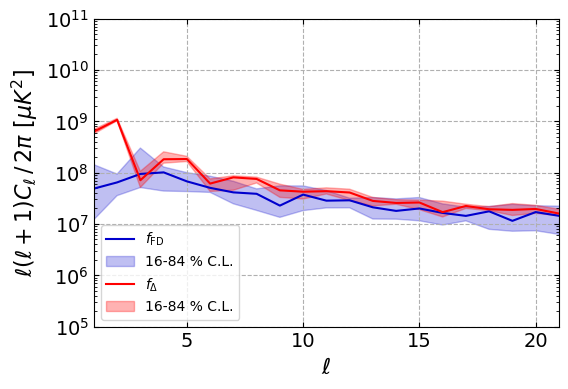

0.05


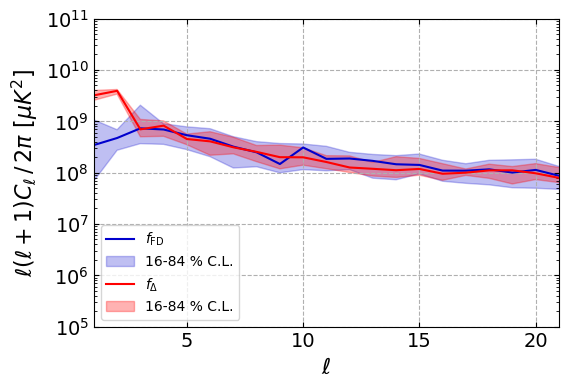

0.1


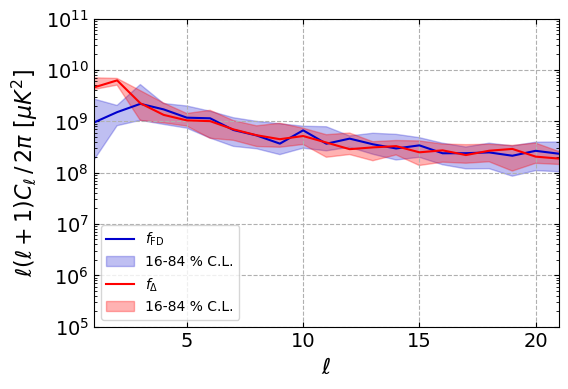

In [6]:
N0_pix = Params.N0 / simdata.Npix
skymap_norm = N0_pix / (Params.cm**-3)
for m_pick in nu_m_picks[0:3]:
    print(m_pick)
    SimPlot.power_spectra_FDxPF(
        m_pick=m_pick, 
        pix_dens_FD=pix_dens_FD - skymap_norm, 
        pix_dens_PF=pix_dens_PF_halos - skymap_norm,
        y_lims=(1e5, 1e11),
        sim_dir=sim_folder, 
        fig_dir=fig_folder,
        args=Params)

### 1 Halo - 10 PFs

2
0.1


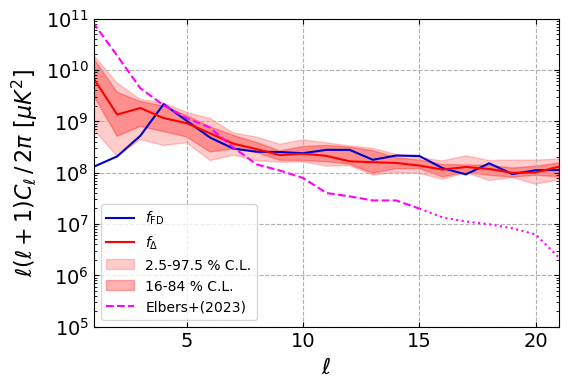

3
0.1


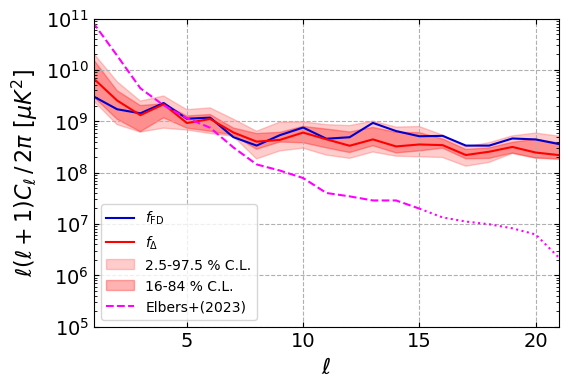

4
0.1


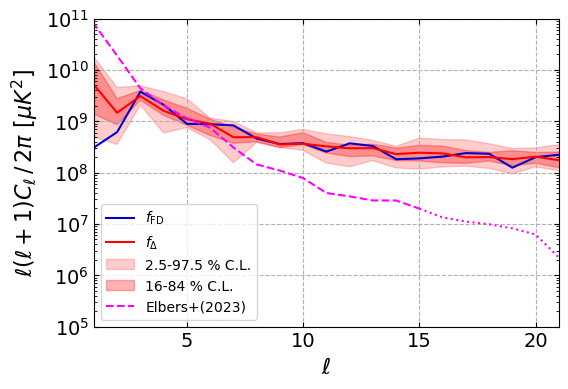

5
0.1


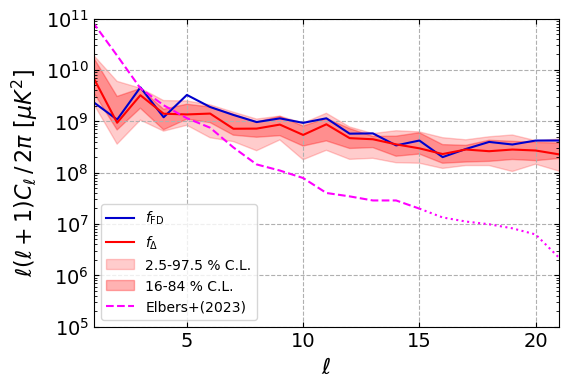

6
0.1


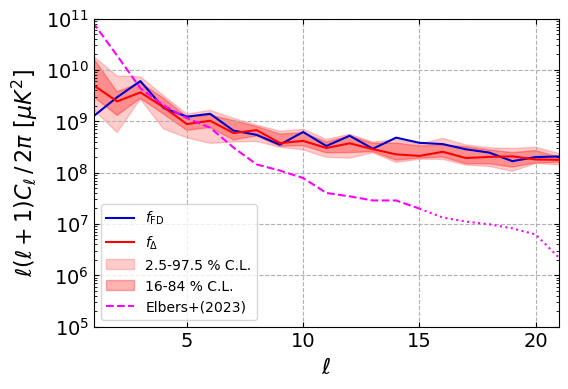

7
0.1


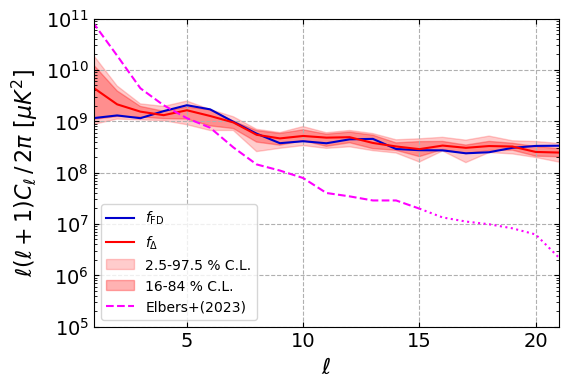

In [8]:
for halo_i in jnp.arange(2,8):

    print(halo_i)

    pix_dens_PF_seeds = jnp.load(f"{sim_folder}/pixel_densities_incl_PFs_seeds_halo{halo_i}.npy")

    N0_pix = Params.N0 / simdata.Npix
    skymap_norm = N0_pix / (Params.cm**-3)
    pix_dens_FD_1Halo = jnp.repeat(pix_dens_FD[halo_i-1][None,...], 10, axis=0)

    for m_pick in nu_m_picks[2:3]:
        print(m_pick)
        SimPlot.power_spectra_FDxPF(
            m_pick=m_pick, 
            pix_dens_FD=pix_dens_FD_1Halo - skymap_norm, 
            pix_dens_PF=pix_dens_PF_seeds - skymap_norm, 
            y_lims=(1e5, 1e11),
            sim_dir=sim_folder, 
            fig_dir=fig_folder,
            args=Params,
            _1Halo=True,
            Elbers=True)

## Percentage in certain velocity range

In [ ]:
def compute_percentages(v_arr, v_min, v_max, m_arr, args):

    vels_z0 = v_arr[:, 0, :]

    # Condition for having neutrinos with velocities in range, today
    mags_z0 = jnp.linalg.norm(vels_z0, axis=-1)*args.kpc/args.s
    cond = (v_min <= mags_z0) & (mags_z0 <= v_max)

    vels_range = v_arr[cond, ...]

    # Compute number densities for neutrinos in velocity range
    dens_range = Physics.number_densities_mass_range(
        vels_range, m_arr, 4*args.Pi, args)

    dens_total = Physics.number_densities_mass_range(
        v_arr, m_arr, 4*args.Pi, args)

    # Percentages 
    perc_range = dens_range/dens_total*100
    percs = [f"{perc:.3f}" for perc in perc_range]
    print(percs)


# Pick a halo
halo_i = 1

# Load velocities
vels = jnp.array(
    [jnp.load(f"{sim_folder}/vectors_halo{i+1}.npy") for i in range(10)]
)[0, ..., 3:].reshape((-1, 2, 3))
# ic(vels.shape)

vels_z0 = vels[:, 0, :]
# ic(vels_z0.shape)

vels_only_z0s = jnp.repeat(jnp.expand_dims(vels_z0, axis=1), repeats=2, axis=1)
# ic(vels_only_z0s.shape)

# Pick velocity range (as in https://arxiv.org/abs/1305.2454), units of c


v_min = 0.01
v_max = 0.14
print(f"Velocities between {v_min}c and {v_max}c :")
print(f"  0.01      0.05       0.1      0.2       0.3   eV")
compute_percentages(v_arr=vels, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())
compute_percentages(v_arr=vels_only_z0s, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())

print("\n")

v_min = 0.001
v_max = 0.01
print(f"Velocities between {v_min}c and {v_max}c :")
print(f"  0.01      0.05       0.1      0.2       0.3   eV")
compute_percentages(v_arr=vels, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())
compute_percentages(v_arr=vels_only_z0s, v_min=v_min, v_max=v_max, m_arr=nu_m_picks, args=Params())

## Momentum distributions

In [ ]:
def momentum_distribution(y_arr, nbins, args):
    """
    Plot a momentum histogram with logarithmically spaced bins.
    """

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(y_arr)), np.log10(np.max(y_arr)), nbins)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot simulation distances
    ax.hist(
        y_arr, bins=log_bins, 
        color="blue", label="CNB simulation", alpha=0.8)
    
    ax.set_xscale("log")
    ax.set_title("Momentum distribution at z=4 (Log Bins)")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()


# Load neutrino vectors for specified halo
halo = 1
nu_vectors = jnp.load(f'{sim_folder}/vectors_halo{halo}.npy')

# Convert to momenta
v_arr = nu_vectors[...,3:]
p_arr, y_arr = Physics.velocities_to_momenta_all_sky(
    v_arr, nu_m_picks, Params())

for m_idx in range(len(nu_m_picks)):
# for m_idx in range(1):

    # Set up plot parameters
    z0_y_arr = y_arr[m_idx, ..., 0].reshape(-1,)
    z4_y_arr = y_arr[m_idx, ...,-1].reshape(-1,)#/(1+4)
    nbins = 50

    # Generating logarithmically spaced bins
    log_bins = np.logspace(
            np.log10(np.min(z0_y_arr)), np.log10(np.max(z0_y_arr)), nbins)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)

    print("**************************************")
    print("Momentum endpoints for Cl(q) generation:")
    print(f"z0: Min = {jnp.min(z0_y_arr)} T_CNB ; Max = {jnp.max(z0_y_arr)} T_CNB")
    print(f"z4: Min = {jnp.min(z4_y_arr)} T_CNB ; Max = {jnp.max(z4_y_arr)} T_CNB")
    print("**************************************\n")

    # print('#? are the highest momenta affected by gravity? If yes how much?')
    # last_x = 5
    # print(jnp.count_nonzero(jnp.abs(z0_y_arr[-last_x:] - z4_y_arr[-last_x:])))
    # diff_high = jnp.abs(z0_y_arr[-last_x:] - z4_y_arr[-last_x:])
    # print(diff_high/z0_y_arr[-last_x:])
    # print('very little difference!\n')

    # print('#? are the lowest momenta affected by gravity? If yes how much?')
    # first_x = 5
    # print(jnp.count_nonzero(jnp.abs(z0_y_arr[:first_x] - z4_y_arr[:first_x])))
    # diff_low = jnp.abs(z0_y_arr[:first_x] - z4_y_arr[:first_x])
    # print(diff_low/z0_y_arr[:first_x])
    # print('more than 1 order of magnitude bigger difference than for higher momenta!\n')
    
    # note: all masses are affected the same due to the nature of gravity, i.e. the fractional differences for the z0/z4 momenta are the same for all masses.
    
    """
    # Sample Fermi-Dirac momenta
    samples = 1_000
    max_p = jnp.max(z0_y_arr*Params.T_CNB)
    print(f"Maximum momentum for Fermi-Dirac sampling = {max_p/Params.T_CNB:.4f} [T_CNB]\n")
    FD_momenta_z0 = Physics.sample_Fermi_Dirac_momentum(
        N=samples, T=Params.T_CNB, p_norm=max_p)
    # p_norm is the maximum momentum sampled, and is used for normalization

    FD_momenta_z4 = FD_momenta_z0*(1+4)

    # Randomly draw from simulation momenta, to match number of Fermi-Dirac samples
    z0_y_sync = jax.random.choice(Params.key, z0_y_arr, shape=(samples,), replace=False)
    z4_y_sync = jax.random.choice(Params.key, z4_y_arr, shape=(samples,), replace=False)

    # Plot momenta
    ax.hist(z0_y_sync, bins=log_bins, color="blue", label="Sim z=0", alpha=0.7)
    ax.hist(z4_y_sync, bins=log_bins, color="red", label="Sim z=4", alpha=0.7)
    ax.hist(FD_momenta_z4/Params.T_CNB, bins=log_bins, color="orange", label="FD z=4", alpha=0.7)

    ax.set_xscale("log")
    ax.set_title(rf"Momentum distribution (Log Bins) for $m_{{\nu}}={nu_m_picks[m_idx]}$")
    ax.set_xlabel(r"$p_\mathrm{back}/T_\mathrm{CNB,0}$")
    ax.set_ylabel("Nr. of neutrinos")
    ax.legend(loc="upper left")

    plt.show(); plt.close()
    """